# Lab 10: Classification

This lab is presented with some revisions from [Dennis Sun at Cal Poly](https://web.calpoly.edu/~dsun09/index.html) and his [Data301 Course](http://users.csc.calpoly.edu/~dsun09/data301/lectures.html)

### When you have filled out all the questions, submit via [Tulane Canvas](https://tulane.instructure.com/)

In [ ]:
# first, mount your google drive, change to the course folder, pull latest changes, and change to the lab folder.
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/cmps3160
# !git pull
%cd _labs/Lab09

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cmps3160
/content/drive/My Drive/cmps3160/_labs/Lab09


_Classification models_ are used when the label we want to predict is categorical. In this section, we will train a classification model to predict the color of a wine (red or white) from its chemical properties.

The training data for the red and white wines are stored in separate files on Github (`../data/reds.csv` and `../data/whites.csv`). Let's read in the two datasets, add a column for the color ("red" or "white"), and combine them into one `DataFrame`.

In [ ]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 5

reds = pd.read_csv("../data/reds.csv", sep=";")
whites = pd.read_csv("../data/whites.csv", sep=";")

reds["color"] = "red"
whites["color"] = "white"

wines = pd.concat([reds, whites],
                  ignore_index=True)
wines

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white
6496,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6,white


Let's focus on just two features for now: volatile acidity and total sulfur dioxide. Let's plot the training data, using color to represent the class label.

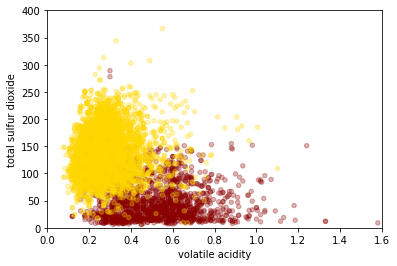

In [ ]:
colors = wines["color"].map({
    "red": "darkred",
    "white": "gold"
})

wines.plot.scatter(
    x="volatile acidity", y="total sulfur dioxide", c=colors,
    alpha=.3, xlim=(0, 1.6), ylim=(0, 400)
);

Now suppose that we have a new wine with volatile acidity .85 and total sulfur dioxide 120, represented by a black circle in the plot below. Is this likely a red wine or a white wine?

![](https://github.com/nmattei/cmps3160/blob/master/_labs/images/classification.png?raw=1)

It is not hard to guess that this wine is probably red, just by looking at the plot. The reasoning goes like this: most of the wines in the training data that were "close" to this wine were red, so it makes sense to predict that this wine is also red. This is precisely the idea behind the $k$-nearest neighbors classifier:

1. Calculate the distance between the new point and each point in the training data, using some distance metric on the features.
2. Determine the $k$ closest points. Of these $k$ closest points, count up how many of each class label there are.
3. The predicted class of the new point is whichever class was most common among the $k$ closest points.

The only difference between the $k$-nearest neighbors classifier and the $k$-nearest neighbors regressor from the previous chapter is the last step. Instead of averaging the labels of the $k$ neighbors to obtain our prediction, we count up the number of occurrences of each category among the labels and take the most common one. It makes sense that we have to do something different because the label is now categorical instead of quantitative. **This is yet another example of the general principle that was introduced in Chapter 1: the analysis changes depending on the variable type!**

# Implementing the K-Nearest Neighbors Classifier

Let's implement $9$-nearest neighbors for the wine above. First, we extract the training data and scale the features:

In [ ]:
X_train = wines[["volatile acidity", "total sulfur dioxide"]]
y_train = wines["color"]

X_train_sc = (X_train - X_train.mean()) / X_train.std()

Then, we create a `Series` for the new wine, being sure to scale it in the exact same way:

In [ ]:
x_new = pd.Series(dtype=float)
x_new["volatile acidity"] = 0.85
x_new["total sulfur dioxide"] = 120

x_new_sc = (x_new - X_train.mean()) / X_train.std()
x_new_sc

volatile acidity        3.099763
total sulfur dioxide    0.075288
dtype: float64

Now we calculate the (Euclidean) distance between this new wine and each wine in the training data, and sort the distances from smallest to largest.

In [ ]:
dists = np.sqrt(((X_train_sc - x_new_sc) ** 2).sum(axis=1))
dists_sorted = dists.sort_values()
dists_sorted

782     0.462062
6391    0.466075
          ...   
3726    5.067728
6344    6.700407
Length: 6497, dtype: float64

The first 9 entries of this sorted list will be the 9 nearest neighbors. Let's get their index.

In [ ]:
inds_nearest = dists_sorted.index[:9]
inds_nearest

Int64Index([782, 6391, 889, 4696, 198, 637, 636, 46, 6414], dtype='int64')

Now we can look up these indices in the original data.

In [ ]:
wines.loc[inds_nearest]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
782,9.0,0.820,0.05,2.4,0.081,26.0,96.0,0.99814,3.36,0.53,10.0,5,red
6391,4.7,0.785,0.00,3.4,0.036,23.0,134.0,0.98981,3.53,0.92,13.8,6,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,7.7,0.935,0.43,2.2,0.114,22.0,114.0,0.99700,3.25,0.73,9.2,5,red
6414,6.2,0.760,0.01,3.2,0.041,18.0,120.0,0.99026,3.20,0.94,13.7,7,white


As a sanity check, notice that these wines are all similar to the new wine in terms of volatile acidity and total sulfur dioxide. To make a prediction for this new wine, we need to count up how many reds and whites there are among these 9-nearest neighbors.

In [ ]:
wines.loc[inds_nearest, "color"].value_counts()

red      6
white    3
Name: color, dtype: int64

There were more reds than whites, so the 9-nearest neighbors model predicts that the wine is red.

As a measure of confidence in a prediction, classification models often report the predicted _probability_ of each label, instead of just the predicted label. The predicted probability of a class in a $k$-nearest neighbors model is simply the proportion of the $k$ neighbors that are in that class. In the example above, instead of simply predicting that the wine is red, we could have instead said that the wine has a $6/9 = .667$ probability of being red.

# K-Nearest Neighbors Classifier in Scikit-Learn

Now let's see how to implement the same $9$-nearest neighbors model above using Scikit-Learn.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# define the training data
X_train = wines[["volatile acidity", "total sulfur dioxide"]]
y_train = wines["color"]

# standardize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)

# fit the 9-nearest neighbors model
model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train_sc, y_train)

# define the test data (Scikit-Learn expects a matrix)
x_new = pd.DataFrame()
x_new["volatile acidity"] = [0.85]
x_new["total sulfur dioxide"] = [120]
x_new_sc = scaler.transform(x_new)

# use the model to predict on the test data
model.predict(x_new_sc)

array(['red'], dtype=object)

What if we want the predicted probabilities? For classification models, there is an additional method, `.predict_proba()`, that returns the predicted probability of each class.

In [ ]:
model.predict_proba(x_new_sc)

array([[0.66666667, 0.33333333]])

The first number represents the probability of the first class ("red") and the second number represents the probability of the second class ("white"). Notice that the predicted probabilities add up to 1, as they must.

# Part 1: Exercises

## Exercise 1

In the above example, we built a 9-nearest neighbors classifier to predict the color of a wine from just its volatile acidity and total sulfur dioxide. Use the model above to predict the color of a wine with the following features:

- fixed acidity: 11
- volatile acidity: 0.3
- citric acid: 0.3
- residual sugar: 2
- chlorides: 0.08
- free sulfur dioxide: 17
- total sulfur dioxide: 60
- density: 1.0
- pH: 3.2
- sulphates: 0.6
- alcohol: 9.8
- quality: 6

Now, build a 15-nearest neighbors classifier using all of the features in the data set. Use this new model to predict the color of the same wine above.

Does the predicted label change? Do the predicted probabilities of the labels change?

In [ ]:
# TYPE YOUR CODE HERE
X_train = wines[["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol", "quality"]]
y_train = wines["color"]

x_new = pd.DataFrame()
x_new["fixed acidity"] = [11]
x_new["volatile acidity"] = [0.3]
x_new["citric acid"] = [0.3]
x_new["residual sugar"] = [2]
x_new["chlorides"] = [0.08]
x_new["free sulfur dioxide"] = [17]
x_new["total sulfur dioxide"] = [60]
x_new["density"] = [1.0]
x_new["pH"] = [3.2]
x_new["sulphates"] = [0.6]
x_new["alcohol"] = [9.8]
x_new["quality"] = [6]

# # fit the 9-nearest neighbors model
# model = KNeighborsClassifier(n_neighbors=9)
# model.fit(X_train_sc, y_train)
# y_train_pred = model.predict(X_train_sc)
# y_train_pred
# accuracy = (y_train_pred == y_train).mean()
# accuracy

scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
x_new_sc = scaler.transform(x_new)

model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train_sc, y_train)

model2 = KNeighborsClassifier(n_neighbors=15)
model2.fit(X_train_sc, y_train)

display("9 neighbor prediction: %s" % model.predict(x_new_sc))
display("9 neighbor probability: %s" % model.predict_proba(x_new_sc))

display("15 neighbor prediction: %s" % model2.predict(x_new_sc))
display("15 neighbor probability: %s" % model2.predict_proba(x_new_sc))

"9 neighbor prediction: ['red']"

'9 neighbor probability: [[1. 0.]]'

"15 neighbor prediction: ['red']"

'15 neighbor probability: [[1. 0.]]'

**Written Answer Here:**
After implementing the model with 9 and 15 neighbors, we see that the results do not vary. The prediction for 9 neighbords yields that the wine will be red. We see this again after running the model with 15 neighbords instead. The probability also remains 1 although this may be a slight computational mistake. I think that the proabability should be less than 1 but should probably not change depending on having 9 or 15 neighbors.

# Part 2: Evaluating Classification Models

Just as with regression models, we need ways to measure how good a classification model is. With regression models, the main metrics were MSE, RMSE, and MAE. With classification models, the main metrics are accuracy, precision, and recall. All of these metrics can be calculated on either the training data or the test data. We can also use cross validation to estimate the value of the metric on test data.

First, let's train a $9$-nearest neighbors model on the wine data, just so that we have a model to evaluate. The following code is copied from above.

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.options.display.max_rows = 5

reds = pd.read_csv("../data/reds.csv", sep=";")
whites = pd.read_csv("../data/whites.csv", sep=";")

reds["color"] = "red"
whites["color"] = "white"

wines = pd.concat([reds, whites],
                  ignore_index=True)
wines

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white
6496,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6,white


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# define the training data
X_train = wines[["volatile acidity", "total sulfur dioxide"]]
y_train = wines["color"]

# standardize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)

# fit the 9-nearest neighbors model
model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train_sc, y_train)

KNeighborsClassifier(n_neighbors=9)

We will start by calculating training metrics, so we need predictions for the observations in the training data.

In [ ]:
y_train_pred = model.predict(X_train_sc)
y_train_pred

array(['red', 'red', 'red', ..., 'white', 'white', 'white'], dtype=object)

# Metrics for Classification

Because the labels $y_i$ in a classification model are categorical, we cannot calculate the difference $y_i - \hat y_i$ between the actual and predicted labels, as we did for regression model. But we can determine if the predicted label $\hat y_i$ is correct ($\hat y_i = y_i$) or not ($\hat y_i \neq y_i$). For example, the **error rate** is defined to be:

$$ \textrm{error rate} = \textrm{proportion where } \hat y_i \neq y_i $$

With classification models, it is more common to report the performance in terms of a score, like **accuracy**, where a higher value is better:

$$ \textrm{accuracy} = \textrm{proportion where } \hat y_i = y_i $$

In [ ]:
accuracy = (y_train_pred == y_train).mean()
accuracy

0.9609050330921964

If you ever forget how to calculate accuracy, you can have Scikit-Learn do it for you. It just needs to know the true labels and the predicted labels:

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_train_pred)

0.9609050330921964

The problem with accuracy is that it is sensitive to the initial distribution of classes in the training data. For example, if 99% of the wines in the data set were white, it would be trivial to obtain a model with 99% accuracy: the model could simply predict that every wine is white. Even though such a model has high overall accuracy, it is remarkably bad for red wines. We need some way to measure the "accuracy" of a model for a particular class.

Suppose we want to know the "accuracy" of our model for class $c$. There are two ways to interpret "accuracy for class $c$". Do we want to know the accuracy among the observations our model _predicted to be_ in class $c$ or the accuracy among the observations that _actually were_ in class $c$? The two options lead to two different notions of "accuracy" for class $c$: precision and recall.

The **precision** of a model for class $c$ is the proportion of observations predicted to be in class $c$ that actually were in class $c$.

$$ \textrm{precision for class } c = \frac{\# \{i:  \hat y_i = c \textrm{ and } y_i = c\}}{\# \{i: \hat y_i = c \}}. $$

The **recall** of a model for class $c$ is the proportion of observations actually in class $c$ that were predicted to be in class $c$.

$$ \textrm{recall for class } c = \frac{\# \{i:  \hat y_i = c \textrm{ and } y_i = c\}}{\# \{i: y_i = c \}}. $$

Another way to think about precision and recall is in terms of true positives (TP) and false positives (FP). A "positive" is an observation that the model identified as belonging to class $c$ (i.e., $\hat y_i = c$). A true positive is one that actually was in class $c$ (i.e., $\hat y_i = c$ and $y_i = c$), while a false positive is one that was not (i.e., $\hat y_i = c$ and $y_i \neq c$). True and false _negatives_ are defined analogously.

In the language of positives and negatives, the precision is the proportion of positives that are true positives:
$$ \textrm{precision for class } c = \frac{TP}{TP + FP}, $$
while the recall is the proportion of observations in class $c$ that are positives (as opposed to negatives):
$$ \textrm{recall for class } c = \frac{TP}{TP + FN}. $$

The diagram below may help you to remember which numbers go in the numerator and denominator. The precision is the proportion of the red rectangle that is a TP, while the recall is the proportion of the red circle that is a TP.

![](https://github.com/nmattei/cmps3160/blob/master/_labs/images/precision_recall.png?raw=1)

Let's calculate the precision and recall of our $9$-nearest neighbors model for the red "class":

In [ ]:
true_positives = ((y_train_pred == "red") & (y_train == "red")).sum()

precision = true_positives / (y_train_pred == "red").sum()
recall = true_positives / (y_train == "red").sum()

precision, recall

(0.926984126984127, 0.9130706691682301)

Again, you can have Scikit-Learn calculate precision and recall for you. These functions work similarly to `accuracy_score` above, except we have to explicitly specify the class for which we want the precision and recall. For example, to calculate the precision and recall of the model for red wines:

In [ ]:
from sklearn.metrics import precision_score, recall_score

(precision_score(y_train, y_train_pred, pos_label="red"),
 recall_score(y_train, y_train_pred, pos_label="red"))

(0.926984126984127, 0.9130706691682301)

It is important to specify `pos_label` because the precision and recall for other classes may be quite different:

In [ ]:
(precision_score(y_train, y_train_pred, pos_label="white"),
 recall_score(y_train, y_train_pred, pos_label="white"))

(0.9717594473791141, 0.9765210289914251)

In general, there is a tradeoff between precision and recall. For example, you can improve recall by predicting more observations to be in class $c$, but this will hurt precision. To take an extreme example, a model that predicts that _every_ observation is in class $c$ has 100% recall, but its precision would likely be poor. To visualize this phenomenon, suppose we expand the positives from the dashed circle to the solid circle, as shown in the figure below, at right. This increases recall (because the circle now covers more of the red rectangle) but decreases precision (because the red rectangle now makes up a smaller fraction of the circle).

![](https://github.com/nmattei/cmps3160/blob/master/_labs/images/precision_recall_tradeoff.png?raw=1)

Likewise, you can improve precision by predicting fewer observations to be in class $c$ (i.e., only the ones you are very confident about), but this will hurt recall. This is illustrated in the figure above, at left.

# Validation Accuracy, Precision, and Recall in Scikit-Learn

We calculated the training accuracy of our classifier above. However, test accuracy is more useful in most cases. We can estimate the test accuracy using cross validation. We will have Scikit-Learn carry out the cross validation for us, including the computation of the accuracy score on each held-out subsample. We simply have to specify the right `scoring=` method.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

pipeline = Pipeline([
    ("scaler", scaler),
    ("model", model)
])

cross_val_score(pipeline, X_train, y_train,
                cv=10, scoring="accuracy")

array([0.94      , 0.94615385, 0.94615385, 0.94307692, 0.95692308,
       0.96769231, 0.94923077, 0.94453005, 0.96918336, 0.94298921])

To obtain a single estimate of test accuracy from the 10 validation accuracies, we can take their average:

In [ ]:
cross_val_score(pipeline, X_train, y_train,
                cv=10, scoring="accuracy").mean()

0.9505933388645254

The validation accuracy is still high, but lower than the training accuracy. This makes sense because it is always harder to predict for future data than for current data.

Scikit-Learn can also calculate the precision and recall of a class $c$, but we need to manually convert the label to a binary label that is $1$ (or `True`) if the observation is in class $c$ and $0$ (or `False`) otherwise. For example, the following code calculates the validation _recall_ for red wines:

In [ ]:
is_red_train = (y_train == "red")

cross_val_score(pipeline, X_train, is_red_train,
                cv=10, scoring="recall").mean()

0.8849567610062893

To calculate the validation _precision_ for red wines, we just have to change the scoring method:

In [ ]:
cross_val_score(pipeline, X_train, is_red_train,
                cv=10, scoring="precision").mean()

0.9137308357621109

# F1 Score: Combining Precision and Recall

We have replaced accuracy by two numbers: precision and recall. We can combine the precision and recall into a single number, called the **F1 score**.

The F1 score is defined to be the **harmonic mean** of the precision and the recall. That is,

$$ \frac{1}{\text{F1 score}} = \frac{ \frac{1}{\text{precision}} + \frac{1}{\text{recall}}}{2}, $$

or equivalently,

$$ \text{F1 score} = \frac{2 \cdot \text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}. $$

The harmonic mean of two numbers is always between the two numbers, but in general will be closer to the smaller number. For example, if precision is $90\%$ and recall is $10\%$, then the harmonic mean is

$$ \text{F1 score} = \frac{2 \cdot 0.9 \cdot 0.1}{0.9 + 0.1} = 18\%. $$

This is a desirable property of F1 scores because we want to encourage models to have both high precision _and_ high recall. It is not sufficient for one of these to be high if the other is very low. In other words, we do not want to allow a high precision to cancel out a low recall, or vice versa.

The F1 score for red wines is:

In [ ]:
2 * precision * recall / (precision + recall)

0.91997479521109

We could have also asked Scikit-Learn calculate this for us. If we know the actual and predicted labels, we can use the `f1_score` function, which works similarly to `precision_score` and `recall_score` from above:

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train, y_train_pred, pos_label="red")

0.91997479521109

We can also have `cross_val_score` calculate and return the F1 scores on each held-out subsample:

In [ ]:
cross_val_score(pipeline, X_train, is_red_train,
                cv=10, scoring="f1")

array([0.87043189, 0.88888889, 0.89361702, 0.87707641, 0.90666667,
       0.93416928, 0.89589905, 0.88679245, 0.93710692, 0.88888889])

# Part 2: Exercises

Exercises 3-5 ask you to use the Titanic data set (`../data/titanic.csv`) to train various classifiers.

## Exercise 3

Build a 5-nearest neighbors model to predict whether or not a passenger on a Titanic would survive, based on their age, sex, and class as features. Use the Titanic data set (`../data/titanic.csv`) as your training data. Calculate the _training_ accuracy, precision, and recall of this model for survivors.

In [ ]:
# TYPE YOUR CODE HERE.
df_t = pd.read_csv("../data/titanic.csv")
df_t.dropna(subset = f, inplace=True)
f = ["age", "sex", "pclass"]

X_train_dict = df_t[f].to_dict(orient="records")
y_train = df_t["survived"]

vec = DictVectorizer(sparse=False)
vec.fit(X_train_dict)
X_train = vec.transform(X_train_dict)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_sc, y_train)

# cross_val_score(pipeline, X_train, y_train,
#                 cv=10, scoring="accuracy")
# cross_val_score(pipeline, X_train, y_train,
#                 cv=10, scoring="accuracy").mean()
# is_red_train = (y_train == "red")
# cross_val_score(pipeline, X_train, is_red_train,
#                 cv=10, scoring="recall").mean()
# cross_val_score(pipeline, X_train, is_red_train, cv=10, scoring="precision").mean()

y_train_pred = model.predict(X_train_sc)

a = accuracy_score(y_train, y_train_pred)
print("The accuracy of this model is : " + str(a))

p = precision_score(y_train, y_train_pred)
print("The precision of this model is : " + str(p))

r = recall_score(y_train, y_train_pred)
print("The recall of this model is : " + str(r))

The accuracy of this model is : 0.8413001912045889
The precision of this model is : 0.8461538461538461
The recall of this model is : 0.747072599531616


## Exercise 4

Estimate the _test_ accuracy, precision, and recall of your model for survivors.

In [ ]:
# TYPE YOUR CODE HERE.
# pipeline = Pipeline([
#     ("scaler", scaler),
#     ("model", model)
# ])
# cross_val_score(pipeline, X_train, y_train,
#                 cv=10, scoring="accuracy")
# cross_val_score(pipeline, X_train, y_train,
#                 cv=10, scoring="accuracy").mean()
# is_red_train = (y_train == "red")

pipeline = Pipeline([("scaler", scaler), ("model", model)])

a = cross_val_score(pipeline, X_train, y_train, cv=10, scoring="accuracy")
a = a.mean()
print("The accuracy of this model is : " + str(a))

p = cross_val_score(pipeline, X_train, y_train, cv=10, scoring="precision")
p = p.mean()
print("The precision of this model is : " + str(p))


r = cross_val_score(pipeline, X_train, y_train, cv=10, scoring="recall")
r = r.mean()
print("The recall of this model is : " + str(r))

The accuracy of this model is : 0.765521978021978
The precision of this model is : 0.736828008910431
The recall of this model is : 0.6740863787375415


## Exercise 5

Use, use your model to predict whether a 20-year old female in first-class would survive. What about a 20-year old female in third-class?

In [ ]:
# TYPE YOUR CODE HERE.
df_t = pd.read_csv("../data/titanic.csv")
df_t.dropna(subset = f, inplace=True)

f = ["age","sex","pclass"]

X_train = df_t[f]
X_train_dict = df_t[f].to_dict(orient="records")

X_new_dict_c1 = [{ "age": 20,
                  'sex': "female",
                  'class': 1,}]

X_new_dict_c3 = [{ "age": 20,
                  'sex': "female",
                  'class': 3,}]

y_train = df_t["survived"]

# # fit the 9-nearest neighbors model
# model = KNeighborsClassifier(n_neighbors=9)
# model.fit(X_train_sc, y_train)
# y_train_pred = model.predict(X_train_sc)
# y_train_pred
# accuracy = (y_train_pred == y_train).mean()
# accuracy

vec = DictVectorizer(sparse=False)
vec.fit(X_train_dict)
X_train = vec.transform(X_train_dict)

X_train = vec.transform(X_train_dict)
X_new_c1 = vec.transform(X_new_dict_c1)
X_new_c3 = vec.transform(X_new_dict_c3)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_sc = scaler.transform(X_train)
X_new_sc_c1 = scaler.transform(X_new_c1)
X_new_sc_c3 = scaler.transform(X_new_c3)

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_sc, y_train)

print("Prediction for a 20 year old female in class 1: %s. This means that this person is likely to survive." % model.predict(X_new_sc_c1))
print("Prediction for a 20 year old female in class 3: %s. This means that this person is also likely to survive" % model.predict(X_new_sc_c3))

Prediction for a 20 year old female in class 1: [1]. This means that this person is likely to survive.
Prediction for a 20 year old female in class 3: [1]. This means that this person is also likely to survive


## Exercise 6

You want to build a $k$-nearest neighbors model to predict where a Titanic passenger embarked, using their age, sex, and class.

- What value of $k$ optimizes overall accuracy?
- What value of $k$ optimizes the F1 score for Southampton?
- Does the same value of $k$ optimize accuracy and the F1 score?

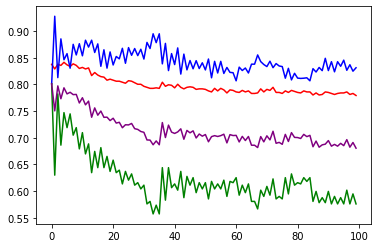

In [ ]:
# TYPE YOUR CODE HERE.
from sklearn.metrics import f1_score

def fillSeries(k):
  vec = DictVectorizer(sparse=False)
  vec.fit(X_train_dict)
  X_train = vec.transform(X_train_dict)

  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train_sc = scaler.transform(X_train)
  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(X_train_sc, y_train)

  y_train_pred = model.predict(X_train_sc)

  accuracy = accuracy_score(y_train, y_train_pred)
  precision = precision_score(y_train, y_train_pred)
  recall = recall_score(y_train, y_train_pred)
  f1 = f1_score(y_train, y_train_pred)

  # display("acurracy is %s" % accuracy)
  # display("precision is %s" % precision)
  # display("recall is %s" % recall)
  # display("f1 is %s" % f1)

  return (accuracy, precision, recall, f1)

df_t = pd.read_csv("../data/titanic.csv")
f = ["age", "sex", "pclass"]
df_t.dropna(subset = f, inplace=True)

X_train_dict = df_t[f].to_dict(orient="records")
y_train = df_t["survived"]

ks = pd.Series(range(1, 101))
ks.index = range(1, 101)

x_graph = pd.DataFrame()
graph = ks.apply(fillSeries)

q = [i[0] for i in graph]
x_graph["accuracy"] = q
x_graph["accuracy"].plot.line(color = "Red")

w = [i[1] for i in graph]
x_graph["precision"] = w
x_graph["precision"].plot.line(color = "Blue")

e = [i[2] for i in graph]
x_graph["recall"] = e
x_graph["recall"].plot.line(color = "Green")

r = [i[3] for i in graph]
x_graph["f1"] = r
x_graph["f1"].plot.line(color = "Purple")

**Written Answers**:
I was unable to determine the varying levels of accuracy, precision, recall and f1 for the "embarked" class because I did not have time to debug my program. My code works with a class that has binary values, such as "survived" which has either holds a 0 or 1. That being said, I did compute the accuracy, precision, recall and f1 for "survived" for K=1 to 100. From the graph we notice that that lower values of K are typically favorable because they yield higher measures. Intuitively, I would think that higher values of K would be more favorable but this is what my program illustrates. The optimal K then appears to be between 1-5 because this is where the graph is highest for each measured value.

**When you have filled out all the questions, submit via [Tulane Canvas](https://tulane.instructure.com/)**